# ICT nudging pipelines notebook

## Introduction

This notebook is part of a series of notebooks presenting the numerical simulations, and the results, for the article **"Realistic Nudging through ICT Pipelines to Help Improve Energy Self-Consumption for Management in Energy Communities".**

### General description
Our model comprises two parts:

1. a **simulated part** which simulates an household consuming energy, and reacting to nudges.

2. a **real world part** which contains the true algorithms processing the available information, and constructing the nudges.

The scheme below shows the various parts of our model. The real world algorithms are plugged on the simulated part, but they can be unplugged, and plugged into the "real world".

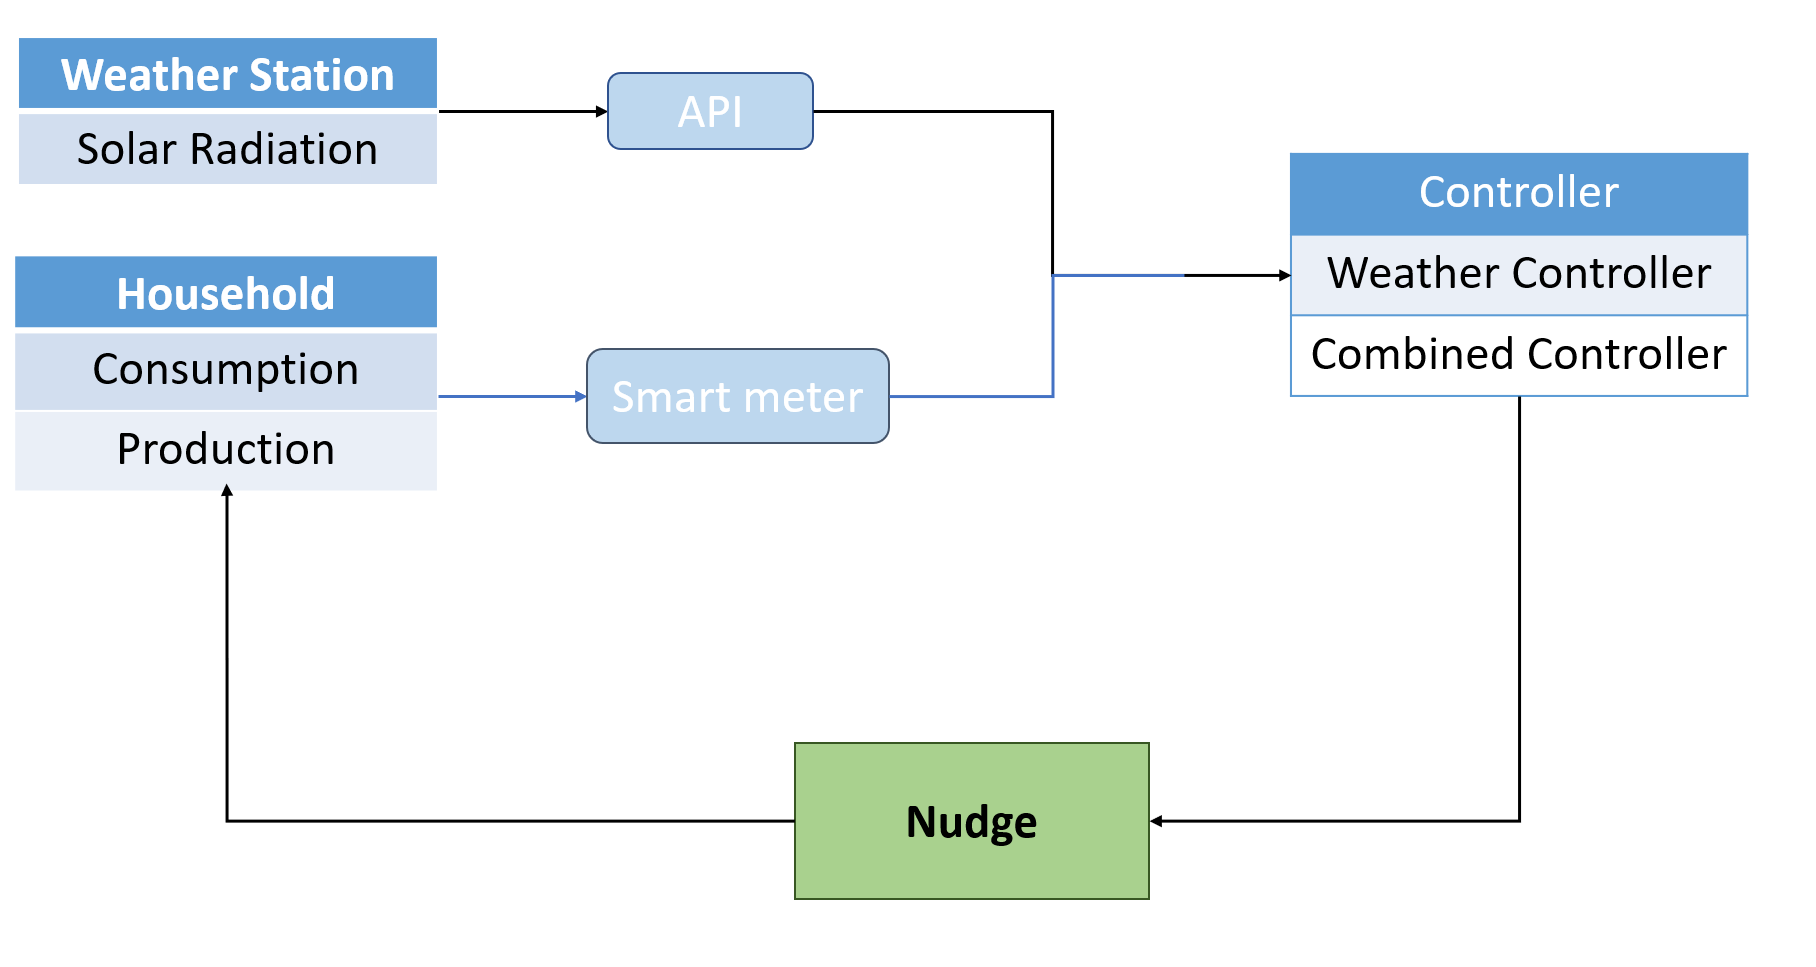

In [1]:
from IPython.display import Image
Image(filename='NudgingPipeline.PNG') 

### Case study 

The numerical simulations presented in **Section 4.6.** the **influence of production levels** on a particular outcome. To conduct the simulations, **we select one building from the Iris dataset**.

**The Iris dataset** is a collection of residential energy consumption data from **98 houses** spanning a period of **one year**, and is a **subset** of a **European database** gathered as part of the **REMODECE project**.

## Setting-up the model and the simulation parameters

We first obtain the absolute path of the current working directory, and import some utils modules.

In [2]:
import os
path = os.path.abspath(os.path.dirname(os.getcwd()))
path = os.path.abspath(os.path.join(os.getcwd(), ".."))
os.chdir(path)
from src.utils import set_simulation_config as sconf
import utils_notebook as ub

### Set simulation parameters
The simulation depends on various parameters, related to the different aspects of the model, in the simulated world, and the real world algorithms.

In the **simulated world**, we have:

1. the **household**;


2. the **solar pannels**;


3. the **general simulation settings.**

The **real world algorithms** are
1. the **controllers** (algorithms which process information and send nudges to the household).

**There are several parameters in the simulation configuration whose values we have fixed**,and for more information, please refer to the notebook "[simple example](https://gitlab.enogrid.ovh/recherche-et-d-veloppement/ml_for_nudging/-/blob/open_source/Notebook_Exemple/Simple_example.ipynb "Go to Example notebook").". 


We define below the main parameters, and briefly comment on them.

### Household settings
Here, all that is required is to specify the location of the data.
This data file contains the energy consumption profiles for each appliance that was measured. We utilized this data to determine the shiftable and non-shiftable profiles.

In [3]:
data_path = "./data/inputs/real_data/iris.csv"

###  Solar pannels

The variable **coeff_sunshine_to_prod** represents the capacity, in Watts, of the solar pannels (that is, their production when sunshine is at its maximum).

In this study, we provide a list of different values of **coeff_sunshin_to_prod** to demonstrate the **impact of production levels** on a nudge system.

In [4]:
coeff_shunshin_to_prod = [500, 1000, 1500, 2500, 3000, 4000, 5000, 6000, 7000, 10000] # production level

During the simulation, we compute synthetic sunshine coefficients. They depend on the time of day, the month of year, and the level of clouds. The sequence of clouds is modelled as a Markov Chain. It is therefore stochastic.

### Controllers settings


We set parameters for our two controllers: Weather Controller, and Combined Controller.

1. **nb_periods_max** : This parameter sets the maximum number of **green periods** labelled by a nudge,The default value is 4. , please refer to the notebook for explanations about this choice ["Influence of the Number of Green Periods"](https://gitlab.enogrid.ovh/recherche-et-d-veloppement/ml_for_nudging/-/blob/open_source/Notebook_Exemple/Influence%20of%20the%20Number%20of%20Green%20Periods.ipynb) and refer to the **Section 4.7.** in our paper.


2. **predictor_type** : this parameter specifies the type of energy forecasting model to use for the Combined Controller. There are two options: a "simple" model (using as consumption prediction past consumption averages for each day, and each 30 minutes time slot), and a "Random Forest" model.

In [5]:
nb_periods_max = [4] # number of green period by nudge
predictor_type = "simple"  # Simple or Random_forest

### General Simulation Settings

Here are some important general parameters for the simulation:

1. **Timeline Data** :The timeline data is used to define both the historical data for training energy forecasting models and the simulation data for nudging simulations. The default values of the timeline configuration are defined in the **'household_timeline.json' file**. If you wish to use alternative values, please consult the notebook "**[simple example](https://gitlab.enogrid.ovh/recherche-et-d-veloppement/ml_for_nudging/-/blob/open_source/Notebook_Exemple/Simple_example.ipynb "Go to Example notebook")**".Here is an example of how to **set the timeline data**. **In this notebook, we use the defaut values of timeline data.**


2. **nb_runs** : The number of simulation runs.



3. **run_optimisation** : If **True**, compare the simulation results obtained from the nudge algorithm with the results obtained from the optimization algorithm calculated by OMEGalpes. **OMEGAlpes** is **a linear optimization tool** designed to easily generate multi-carrier energy system models. Its purpose is to assist in developing district energy projects by integrating design and operation in pre-studies phases. For more informations, please refer to [OMEGalpes](https://omegalpes.readthedocs.io/en/stable/about_OMEGAlpes.html)

In [6]:
nb_runs = 15  
run_optimisation=False
## we use default values of timeline configuration at 'household_timeline.json' file
sim_conf=sconf.SimulationConfig(data_path,
                                nb_periods_max,predictor_type,
                                coeff_shunshin_to_prod)
cfg = sim_conf.simlation_config

## Running simulation

To account for the stochastic of production generation, we have **averaged the results of 15 simulation runs** for **each sunshine coefficient**.

This approach helps to reduce the impact of random variations in production levels on the overall results of the simulation, providing a more accurate picture of the relationship between energy production and self_consumption/sufficiency rate.


In [ ]:
run_sim = sconf.RunSimulation(sim_conf, run_optimisation=run_optimisation,nb_runs=nb_runs, nb_periods_max=nb_periods_max, coeff_sunshine=coeff_shunshin_to_prod)
result = run_sim.run_simulation()
result = result*100

## Visualization

To assess the impact of the nudge, we examine the changes in self-consumption and self-sufficiency rates resulting from the intervention of the Controller (represented by the orange line for the Combined Controller and blue line for the Weather Controller) compared to the Reference for each production level. The data is based on an average of 15 simulations for each production level, and the shaded area illustrates the range of values obtained from these simulations.

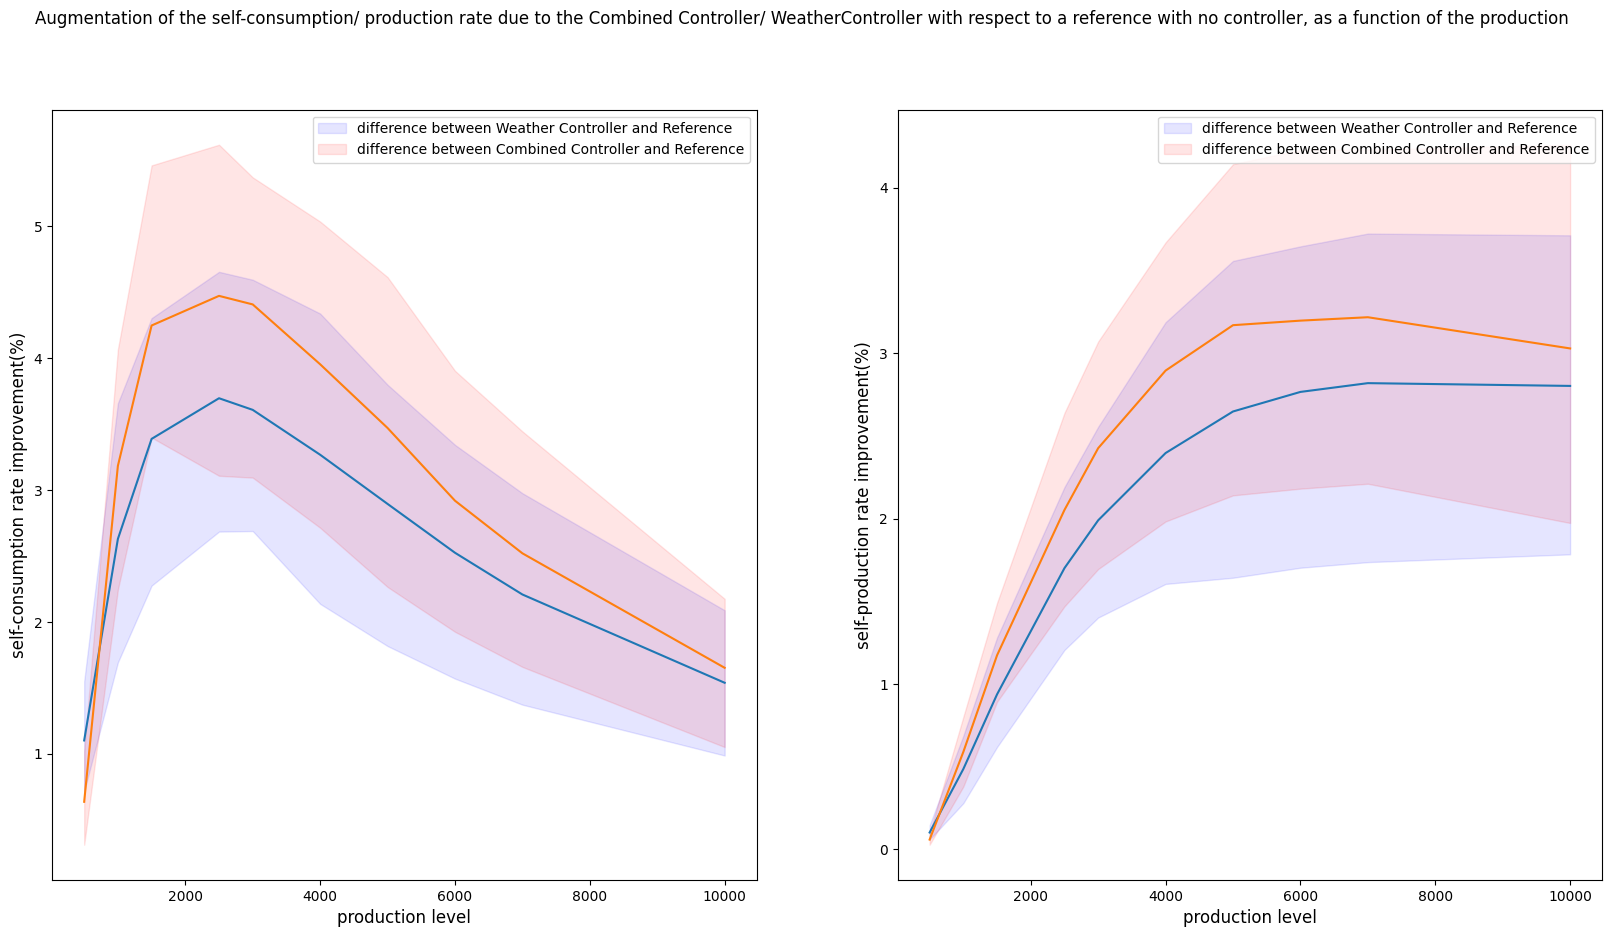

In [8]:
collection_infos_df = result.transpose()
ub.visualisation_influence_of_production_level(coeff_shunshin_to_prod,collection_infos_df, nb_runs)

## Conclusion

We see that the increase of the self-consumption rate is **maximum** for a production between **2000-3000 W** for both cases of controllers, and that it decreases for lower, and larger, values of production. Indeed, when there is very few production, there are not much gain to target by shifting consumption, therefore nudging does not help a lot. Likewise, when there is a lot of production, all consumption already takes place when solar production is high, therefore there is no need to shift consumption. On the contrary, for intermediate values of production, shifting may help improve self-consumption, and therefore nudging proves valuable

As the production level increases, the improvement in **self-sufficiency rate** also increases; however, at a certain point **(7000-8000 W)**, the increase in self-sufficiency rate will reach **a plateau and stop growing.**